In [39]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rossco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 512

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
#dataset_filename = os.listdir("../input")[0]
#dataset_path = os.path.join("..","input",dataset_filename)
#print("Open file:", dataset_path)
df = pd.read_csv((r'D:\Python projects\LampProject\training.1600000.processed.noemoticon.csv'), encoding =DATASET_ENCODING , names=DATASET_COLUMNS)


In [5]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [6]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 375 ms
Wall time: 387 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

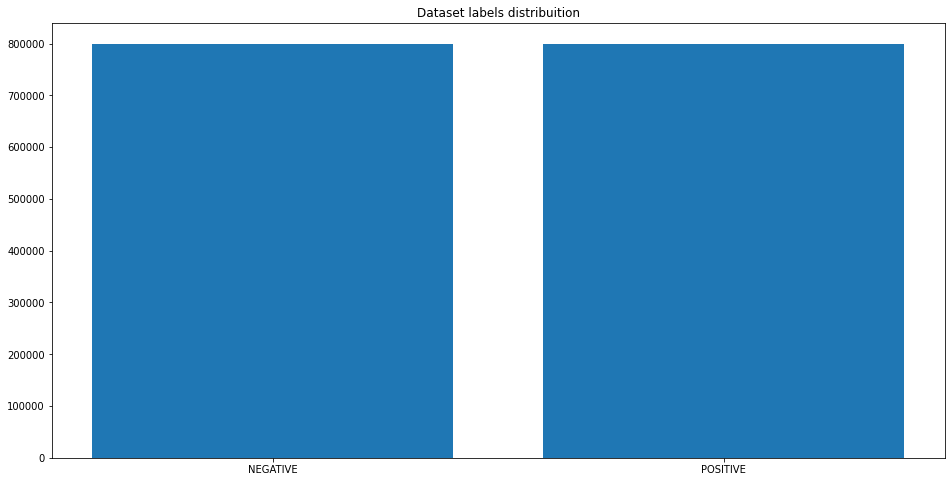

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 47.9 s
Wall time: 53.6 s


In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 2.84 s
Wall time: 3.12 s


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2022-04-06 22:13:31,681 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2022-04-06T22:13:31.681239', 'gensim': '4.1.2', 'python': '3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19043-SP0', 'event': 'created'}


In [16]:
w2v_model.build_vocab(documents)

2022-04-06 22:13:31,730 : INFO : collecting all words and their counts
2022-04-06 22:13:31,730 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-04-06 22:13:31,746 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2022-04-06 22:13:31,765 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2022-04-06 22:13:31,785 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2022-04-06 22:13:31,804 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2022-04-06 22:13:31,824 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2022-04-06 22:13:31,843 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2022-04-06 22:13:31,863 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2022-04-06 22:13:31,882 : INFO : PROGRESS: at s

In [40]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-04-06 22:13:54,239 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-04-06T22:13:54.239752', 'gensim': '4.1.2', 'python': '3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19043-SP0', 'event': 'train'}
2022-04-06 22:13:55,268 : INFO : EPOCH 1 - PROGRESS: at 9.66% examples, 786462 words/s, in_qsize 14, out_qsize 1
2022-04-06 22:13:56,273 : INFO : EPOCH 1 - PROGRESS: at 19.51% examples, 796635 words/s, in_qsize 15, out_qsize 0
2022-04-06 22:13:57,324 : INFO : EPOCH 1 - PROGRESS: at 29.05% examples, 779131 words/s, in_qsize 15, out_qsize 0
2022-04-06 22:13:58,332 : INFO : EPOCH 1 - PROGRESS: at 38.78% examples, 783173 words/s, in_qsize 16, out_qsize 0
2022-04-06 22:13:59,362 : INFO : EPOCH 1 - PROGRESS: at 47.97% examples, 773469 words/s, in_qsize 15, out_qsize 0
2022-04-06 

CPU times: total: 14min 50s
Wall time: 4min 40s


(263120601, 295270528)

In [20]:
w2v_model.wv.most_similar("love")

[('luv', 0.5794763565063477),
 ('loves', 0.5458441972732544),
 ('loved', 0.5345573425292969),
 ('adore', 0.529651939868927),
 ('amazing', 0.5056285262107849),
 ('looove', 0.48844581842422485),
 ('awesome', 0.46642574667930603),
 ('loveee', 0.4464726150035858),
 ('lovee', 0.4418674111366272),
 ('miss', 0.4331274926662445)]

In [21]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: total: 16.4 s
Wall time: 18 s


In [22]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 20.8 s
Wall time: 23.1 s


In [23]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [28]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-04-06 22:24:30,168 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [29]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [45]:
import tensorflow as tf

In [38]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Num GPUs Available:  1
True


In [55]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
2250/2250 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.7482WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-04-07 01:00:19,881 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2250/2250 [==============================] - 7089s 3s/step - loss: 0.5082 - accuracy: 0.7482 - val_loss: 0.4634 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 2/8
2250/2250 [==============================] - ETA: 0s - loss: 0.4815 - accuracy: 0.7655WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-04-07 02:58:26,916 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2250/2250 [==============================] - 7087s 3s/step - loss: 0.4815 - accuracy: 0.7655 - val_loss: 0.4558 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 3/8
2250/2250 [==============================] - ETA: 0s - loss: 0.4744 - accuracy: 0.7698WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-04-07 04:56:18,286 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2250/2250 [==============================] - 7071s 3s/step - loss: 0.4744 - accuracy: 0.7698 - val_loss: 0.4546 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 4/8
2250/2250 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.7722WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-04-07 06:54:09,486 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2250/2250 [==============================] - 7071s 3s/step - loss: 0.4706 - accuracy: 0.7722 - val_loss: 0.4529 - val_accuracy: 0.7871 - lr: 0.0010
Epoch 5/8
2250/2250 [==============================] - ETA: 0s - loss: 0.4674 - accuracy: 0.7744WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-04-07 08:51:27,353 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2250/2250 [==============================] - 7038s 3s/step - loss: 0.4674 - accuracy: 0.7744 - val_loss: 0.4493 - val_accuracy: 0.7885 - lr: 0.0010
Epoch 6/8
2250/2250 [==============================] - ETA: 0s - loss: 0.4661 - accuracy: 0.7756WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-04-07 10:48:18,714 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2250/2250 [==============================] - 7011s 3s/step - loss: 0.4661 - accuracy: 0.7756 - val_loss: 0.4505 - val_accuracy: 0.7877 - lr: 0.0010
Epoch 7/8
2250/2250 [==============================] - ETA: 0s - loss: 0.4644 - accuracy: 0.7763WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-04-07 12:44:38,240 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2250/2250 [==============================] - 6980s 3s/step - loss: 0.4644 - accuracy: 0.7763 - val_loss: 0.4491 - val_accuracy: 0.7898 - lr: 0.0010
Epoch 8/8
2250/2250 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.7770WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-04-07 14:40:55,150 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2250/2250 [==============================] - 6977s 3s/step - loss: 0.4638 - accuracy: 0.7770 - val_loss: 0.4487 - val_accuracy: 0.7889 - lr: 0.0010
CPU times: total: 1d 48min 47s
Wall time: 15h 38min 44s


In [56]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

625/625 [==============================] - 133s 212ms/step - loss: 0.4473 - accuracy: 0.7894

ACCURACY: 0.7894499897956848
LOSS: 0.4473389685153961
CPU times: total: 2min 1s
Wall time: 2min 13s


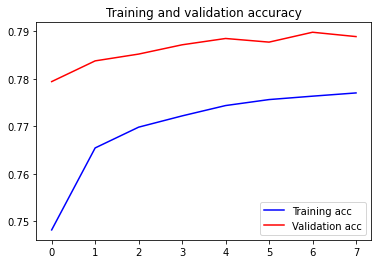

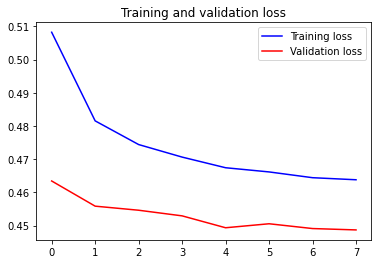

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [60]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [61]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [62]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9721326231956482,
 'elapsed_time': 1.329482078552246}

In [65]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=524)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

611/611 [==============================] - 139s 226ms/step
CPU times: total: 1min 52s
Wall time: 2min 19s


In [66]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

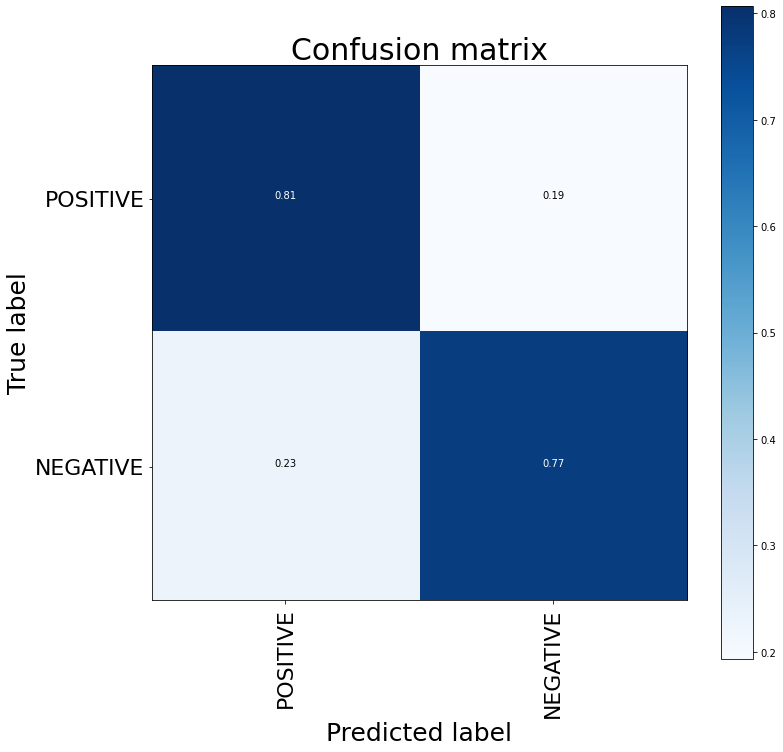

CPU times: total: 1.22 s
Wall time: 1.42 s


In [67]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [68]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.81      0.79    159494
    POSITIVE       0.80      0.77      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [69]:
accuracy_score(y_test_1d, y_pred_1d)

0.78945

In [70]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-04-07 15:00:40,013 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-04-07T15:00:40.013630', 'gensim': '4.1.2', 'python': '3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19043-SP0', 'event': 'saving'}
2022-04-07 15:00:40,016 : INFO : not storing attribute cum_table
2022-04-07 15:00:40,793 : INFO : saved model.w2v
